In [1]:
import numpy as np
import pandas as pd
import datetime
from netCDF4 import Dataset
from mpl_toolkits.basemap import addcyclic
import xarray
import os, sys
from subprocess import call
import brewer2mpl
from pylab import *
import matplotlib.dates as mdates

In [2]:
runlocal=True
calculate_light=True
calculate_seaice=False

if not runlocal: datapath='/cluster/projects/nn9297k/CMIP6/REGRID/'
else: datapath='/Users/trondkr/Dropbox/Projects/Paper27/CMIP6/REGRID/'
  
if calculate_seaice:
    modelvars = ['albisccp', 'sisnthick', 'sithick', 'siconc', 'sisnconc', 'phyc', 'rss', 'cl', 'intpp']
if calculate_light:
    modelvars=["sit","sic","snd","ialb"] # order is important
    
grid_labels = ['gn'] 

ensembles = ['r1i1p1f1', 'r1i1p1f2', 'r1i1p1f3', 'r2i1p1f1', 'r2i1p1f2', 'r2i1p1f3', 'r3i1p1f1', 'r3i1p1f2', 
'r4i1p1f1', 'r4i1p1f2', 'r4i1p1f3', 'r5i1p1f1', 'r5i1p1f2', 'r5i1p1f3', 'r6i1p1f1', 'r6i1p1f2', 'r6i1p1f3', 'r7i1p1f1', 'r7i1p1f2',
'r7i1p1f3', 'r8i1p1f1', 'r8i1p1f2', 'r8i1p1f3', 'r9i1p1f1', 'r9i1p1f2', 'r9i1p1f3', 'r102i1p1f1', 'r102i1p1f2', 'r102i1p1f3']
ensembles = ['r1i1p1f1']

xpts = [ '1pctCO2' ] ## experiment ( could be more )
models = [ 'EC-Earth3-Veg', 'UKESM1-0-LL', 'GFDL-CM4', 'HadGEM3-GC31-LL', 'GISS-E2-1-G']
models = [ 'GFDL-CM4']
subsetdata=True

yearsOfSmoothing=1
useSmoothing=False
scenarios=["1pctCO2"]
selectedMonths=[9]
yearsToExtract=np.arange(1850,2100,1)

if not runlocal:
    workDir="/cluster/projects/nn9297k/CMIP6/REGRID/1pctCO2/"
    workDirHist="/cluster/projects/nn9297k/CMIP6/REGRID/Historical/"
else:
    workDir="REGRID/1pctCO2/"
    workDirHist="REGRID/Historical/"


Convert this script to pure Python
`jupyter nbconvert --execute plot-CMIP6-timeseries.ipynb --to 'python'`

### Steps to caclulate light in the water column
<ul>
<li>
    extractIce.py - extract ice coverage data for region and create timeseries
</li>
<li>
    extractIceThickness.py - extract ice thickness for region and create timeseries
</li>
<li>
    extractIceAge.py - extract the age of ice for region and create timeseries
</li>
<li>
calculateMaxLight.py - Calculate light at depth in water column under sea ice and snow for region and create timeseries 
</li>
</ul>

### Improvements to consider
<ul>
<li>Add effect of increased river runoff on particulate matter and the effect on light</li>

</ul>

In [3]:
def calculateTotalIceArea(month,year,icedata,lon,lat):
    totalarea=0
    lons,lats=np.meshgrid(lon,lat)
    area = calculateArea(lats[0:-1,0:-1],lats[1:,1:],lons[0:-1,0:-1],lons[1:,1:],icedata[0:-1,0:-1],month)
    totalarea=np.sum(area)
                
    print(("Total area with ice for month: {} year: {} -> {} ".format(month,year,totalarea)))
    
    return totalarea

In [4]:
def plotTimeseries(ts,myvar):

    ts_annual = ts.resample("A")
    ts_quarterly = ts.resample("Q")
    ts_monthly = ts.resample("M")

    # Write data to file
    mypath="%s_annualaverages.csv"%(myvar)
    if os.path.exists(mypath):os.remove(mypath)
    ts.to_csv(mypath)
    print("Wrote timeseries to file: %s"%(mypath))

    red_purple = brewer2mpl.get_map('RdPu', 'Sequential', 9).mpl_colormap
    colors = red_purple(np.linspace(0, 1, 12))
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
   # for mymonth in xrange(12):
        #ts[(ts.index.month==mymonth+1)].plot(marker='o', color=colors[mymonth],markersize=5, linewidth=0,alpha=0.8)
    #hold(True)
    ts_annual.plot(marker='o', color="#FA9D04", linewidth=0,alpha=1.0, markersize=7, label="Annual")
    remove_border(top=False, right=False, left=True, bottom=True)
    #ts_monthly.plot(style="r", marker='o', linewidth=1,label="Monthly")

    # legend(loc='best')
    ylabel(r'Light (W m$^{-2})$')

    plotfile='figures/timeseries_'+str(myvar)+'.pdf'
    plt.savefig(plotfile,dpi=300,bbox_inches="tight",pad_inches=0)
    print('Saved figure file %s\n'%(plotfile))
    plt.show()

In [5]:
def calculateArea(lat0,lat1,lon0,lon1,areaIce,month):
    
    earthRadius = 6371000
    rad = np.pi / 180.0
    
    """    -180 <= lon0 < lon1 <= 180
            -90 <= lat0 < lat1 <= 90
            areaIce is in percent
    """

    area = earthRadius**2 * (np.sin(lat1*rad)-np.sin(lat0*rad)) * (lon1 - lon0) * rad
    # Convert from m2 to km2 by dividing by 1.e6
    return (area * (areaIce/ 100.0))/1.e6

In [6]:
"""Function that opens a CMIP5 file and reads the contents. The innput
is assumed to be on grid 0-360 so all values are shifted to new grid
on format -180 to 180 using the shiftgrid function of basemap."""
def openCMIP6file(selectedMonth,useSmoothing,CMIP6Hist,CMIP6Proj,myvar,yearsOfSmoothing,yearsToExtract,modelName,scenario,outfilenameResults):

    if os.path.exists(CMIP6Hist):
        myfileHist=Dataset(CMIP6Hist)
        print(("Opened CMIP6 file:{}".format(CMIP6Hist)))
    else:
        print(("Could not find CMIP5 input file {} : abort".format(CMIP6Hist)))
        sys.exit()

    if os.path.exists(CMIP6Proj):
        myfileProj=Dataset(CMIP6Proj)
        print(("Opened CMIP6 file: %s"%(CMIP6Proj)))
    else:
        print(("Could not find CMIP6 input file {} : abort".format(CMIP6Proj)))
        sys.exit()
        
    timeHist=myfileHist.variables["time"][:]
    timeProj=myfileProj.variables["time"][:]
    refDateH=myfileHist.variables["time"].units
    refDateP=myfileProj.variables["time"].units
    
    if (str(refDateP[11:15])=="0001"):
        refdateProj=datetime.datetime(int(2001),1,1,0,0,0)
    else:
        refdateProj=datetime.datetime(int(refDateP[11:15]),1,1,0,0,0)
    refdateHist=datetime.datetime(int(refDateH[11:15]),1,1,0,0,0)
    
    startH=refdateHist + datetime.timedelta(days=float(timeHist[0]))
    endH=refdateHist + datetime.timedelta(days=float(timeHist[-1]))    
    startP=refdateProj + datetime.timedelta(days=float(timeProj[0]))
    endP=refdateProj + datetime.timedelta(days=float(timeProj[-1]))
    
    print(("Found Historical to start in year {} and end in {}".format(startH.year,endH.year)))
    print(("Found Projections to start in year {} and end in {}".format(startP.year,endP.year)))
    
    """Create the datetime objects for pandas"""
    mydates=[]; startProjectionIndex=-9
    for t in timeHist:
        mydates.append(refdateHist + datetime.timedelta(days=t))
    
    # Since historical and projections can overlap in time, find the first index where historical 
    # values are no longer present in timeseries.
    lastHistoricalDate=mydates[-1]
    firstProjectionIndex=-9; counter=0
    for t in timeProj:
        working=refdateProj + datetime.timedelta(days=t)
        if (working > lastHistoricalDate):
          
            if firstProjectionIndex==-9:
                firstProjectionIndex=counter
            mydates.append(working)
        counter+=1
        
    """Now extract the data for given year"""
    print("firstProjectionIndex {}".format(firstProjectionIndex))
    myTEMPHIST=np.squeeze(myfileHist.variables[myvar][:])
       
    myTEMPHIST=np.ma.masked_where(myTEMPHIST==myTEMPHIST.fill_value,myTEMPHIST)
    myTEMPPROJ=np.squeeze(myfileProj.variables[myvar][firstProjectionIndex:,:,:])
    myTEMPPROJ=np.ma.masked_where(myTEMPPROJ==myTEMPHIST.fill_value,myTEMPPROJ)
            
    lonCMIP6=np.squeeze(myfileHist.variables["lon"][:])
    latCMIP6=np.squeeze(myfileHist.variables["lat"][:])
    
    """Combine the time arrays"""
    timeFull = np.ma.concatenate((timeHist,timeProj[startProjectionIndex:]),axis=0)
    """Combine the myvarname arrays"""
    
    dataFull = np.ma.concatenate((myTEMPHIST,myTEMPPROJ),axis=0)
    dataFull = dataFull
   
    """Make sure that we have continous data around the globe"""
    dataFull, loncyclicCMIP6 = addcyclic(dataFull,lonCMIP6)
    print("Finished")
    lons,lats=np.meshgrid(loncyclicCMIP6,latCMIP6)

        
    """Calculate the climatology 1961-1990"""
    startI=False; endI=False; startIndex=-99; endIndex=99999999
    for index,mydate in enumerate(mydates):
        if startI==False and mydate.year==1961:
            startIndex=index
            startI=True
        if endI==False and mydate.year==1990:
            endIndex=index
            endI=True
        
    print(("Climatology will be calculated for period: {} to {}".format(mydates[startIndex].year, mydates[endIndex].year)))
    climatology=np.ma.zeros((dataFull.shape[1],dataFull.shape[2]))
    
    for i in range(dataFull.shape[1]):
        for j in range(dataFull.shape[2]):
            climatology[i,j]=np.ma.mean(dataFull[startIndex:endIndex,i,j])
         
    """Calculate running mean for entire timeseries"""
    dataSmooth=np.ma.zeros(np.shape(dataFull))
    
    """Now extract only the data for the years we ware interested in saving to file:"""
    dataSmoothSelected=np.ma.zeros(((len(yearsToExtract)+1)*12,dataSmooth.shape[1],dataSmooth.shape[2]), dtype=np.float)
    iceArea=[]
    iceTime=[]  
    counter=0
  
    for index,mydate in enumerate(mydates):
        
        if (mydate.year in yearsToExtract):
           
            dataSmoothSelected[counter,:,:]=dataFull[index,:,:]
            dataSmoothSelected[counter,:,:]=np.ma.masked_invalid(dataSmoothSelected[counter,:,:])
            
          #  if mydate.month == selectedMonth:
               # plotMap(lons,lats,np.ma.masked_invalid(dataSmoothSelected[counter,:,:]),modelName,scenario,mydate,"regular")
                #print " -> Extracted data for year/month %s/%s - %3.3f"%(mydate.year,mydate.month,np.sum(dataSmoothSelected[counter,:,:])-np.sum(climatology))
                 
            iceArea.append(calculateTotalIceArea(mydate.month,mydate.year,dataSmoothSelected[counter,:,:],loncyclicCMIP6,latCMIP6))
            iceTime.append(mydate)
            
            counter+=1
    
    ts=pd.Series(iceArea,iceTime)
    
    plotTimeseries(ts,"icearea")

In [7]:
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
              
def plotTimeseries(ts,myvar):
    
    ts_annual = ts.resample("A")
    
    red_purple = brewer2mpl.get_map('RdPu', 'Sequential', 9).mpl_colormap
    colors = red_purple(np.linspace(0, 1, 12))
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    # Write data to file
    mypath="%s_annualaverages.csv"%(myvar)
    if os.path.exists(mypath):os.remove(mypath)
    ts.to_csv(mypath)
    print(("Wrote timeseries to file: {}".format(mypath)))

    #for mymonth in xrange(12):
    #    ts[(ts.index.month==mymonth+1)].plot(marker='o', color=colors[mymonth],markersize=5, linewidth=0,alpha=0.8)
    #    hold(True)
    ts_annual.plot(marker='o', color="#FA9D04", linewidth=0,alpha=1.0, markersize=7, label="Annual")
    
    remove_border(top=False, right=False, left=True, bottom=True)
   
    ylabel(r'Icea area (million km$^{2})$')
      
    plotfile='figures/timeseries_'+str(myvar)+'.png'
    plt.savefig(plotfile,dpi=300,bbox_inches="tight",pad_inches=0)
    print(('Saved figure file {}\n'.format(plotfile)))
    #plt.show()

Opened CMIP6 file:SUBSET/siconc_GFDL-CM4_historical_r1i1p1f1_gn_185001-201412_regrid_Arctic.nc
Opened CMIP6 file: SUBSET/siconc_GFDL-CM4_1pctCO2_r1i1p1f1_gn_000101-015012_regrid_Arctic.nc
Found Historical to start in year 1850 and end in 2014
Found Projections to start in year 2001 and end in 2150
firstProjectionIndex 166


/Users/trondkr/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/trondkr/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Finished
Climatology will be calculated for period: 1961 to 1990
Total area with ice for month: 1 year: 1850 -> 11773427.31270989 
Total area with ice for month: 2 year: 1850 -> 12151791.039127335 
Total area with ice for month: 3 year: 1850 -> 12236494.901656246 
Total area with ice for month: 4 year: 1850 -> 12075774.15760185 
Total area with ice for month: 5 year: 1850 -> 10725711.513262602 
Total area with ice for month: 6 year: 1850 -> 8673341.507618517 
Total area with ice for month: 7 year: 1850 -> 6622799.447936731 
Total area with ice for month: 8 year: 1850 -> 5282217.844133926 
Total area with ice for month: 9 year: 1850 -> 5232771.304171352 
Total area with ice for month: 10 year: 1850 -> 7761875.827516135 
Total area with ice for month: 11 year: 1850 -> 9883748.035695292 
Total area with ice for month: 12 year: 1850 -> 11353757.030682784 
Total area with ice for month: 1 year: 1851 -> 11964337.632223329 
Total area with ice for month: 2 year: 1851 -> 12214256.045839066 
To

/Users/trondkr/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


FileNotFoundError: [Errno 2] No such file or directory: 'figures/timeseries_icearea.png'

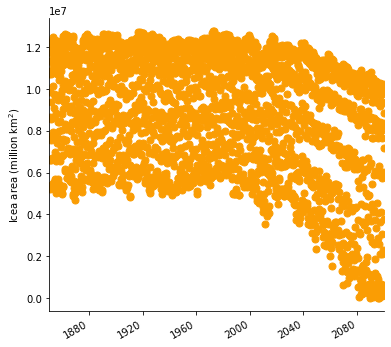

In [8]:
for xpt in xpts:
    for grid_label in grid_labels:
        for model in models:
            for ensemble in ensembles:
                first=True
                for modelvar in modelvars:
                    for selectedMonth in selectedMonths:
                        CMIP6file= '{}{}/{}_{}_{}_{}_{}_000101-015012_regrid.nc'.format(datapath,xpt,modelvar,model,xpt,ensemble,grid_label)
                        CMIP6HISTfile= '{}historical/{}_{}_historical_{}_{}_185001-201412_regrid.nc'.format(datapath,modelvar,model,ensemble,grid_label)
                           
                        